# 0.) Load Libraries and Setup Datapaths

In [1]:
# Load libraries
%matplotlib inline
import cv2
import IPython.display as disp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand
import re
import seaborn as sns
import sys
import tensorflow as tf

from itertools import product
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from os.path import isdir, isfile, join as osjoin
from random import shuffle

# Setup datapaths
base_path = './datasets/IntelImageClassification/'

pred_path = 'seg_pred/seg_pred/'
test_path = 'seg_test/seg_test/'
train_path = 'seg_train/seg_train/'

# Func. to make full paths from base_path
def route(*args):
    full_path = base_path
    for a in args:
        full_path = osjoin(full_path, a)
        
    return full_path

# Make sure paths exist
if isdir(base_path):
    msg = "Couldn't find the dataset path {}. Please check that it is correct."
    
    if not isdir(route(pred_path)):
        print(msg.format(route(pred_path)))
    if not isdir(route(test_path)):
        print(msg.format(route(train_path)))
    if not isdir(route(train_path)):
        print(msg.format(route(train_path)))
else:
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")

# 1.) Load Images

In [2]:
# Generate labels
labels = []
for folder in listdir(route(train_path)):
    assert(isdir(route(test_path, folder))) # Sanity check
    labels.append(folder)
    
# Func. to eliminate code reuse in loading images
# (adapted from Assignment document)
def load_img(path, x, y):
    for f in sorted([_ for _ in listdir(path) if _.lower().endswith('.jpg')]):
        x += [cv2.resize(cv2.imread(osjoin(path,f)), IMGSIZE)]
        y += [labels.index(label)]
        
    return x, y

In [3]:
%%time
# Load images (adapted from Assignment document)
IMGSIZE = (128, 128)
x_tr, y_tr, x_ts, y_ts = [], [], [], []
for label in labels:
    tr_path = route(train_path, label)
    x_tr, y_tr = load_img(tr_path, x_tr, y_tr)
      
    ts_path = route(test_path, label)
    x_ts, y_ts = load_img(ts_path, x_ts, y_ts)

CPU times: user 8.46 s, sys: 3.05 s, total: 11.5 s
Wall time: 19 s


In [4]:
# Check the number of channels
channels = len(x_tr[0][0][0])

# Since these are coloured images we expect 3
disp.display_markdown(f"__Number of Channels:__ {channels}", raw=True)

assert(channels == 3)

__Number of Channels:__ 3

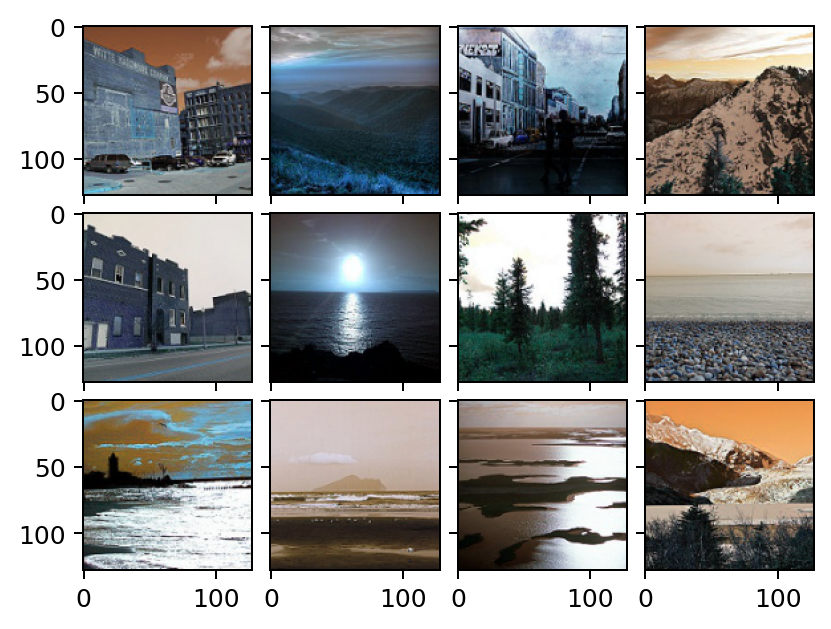

In [5]:
# Display some random images
nrow, ncol = 3, 4
num = nrow * ncol

sample_images = rand.sample(x_tr, num)

fig = plt.figure(dpi=180)
grid = ImageGrid(fig, 111, nrows_ncols=(nrow, ncol), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im)

plt.show()

# 2.) Convert Imageset to Numpy Array and Scale

In [6]:
# Convert
x_tr = np.array(x_tr, dtype=np.float)
y_tr = np.array(y_tr)

x_ts = np.array(x_ts, dtype=np.float)
y_ts = np.array(y_ts)

# Scale
x_tr /= 255.0
x_ts /= 255.0

# Check sanity on shapes
disp.display_markdown(f"__Training Set Shape:__ {x_tr.shape}", raw=True)
disp.display_markdown(f"__Testing Set Shape:__ {x_ts.shape}", raw=True)

disp.display_markdown(f"__Training Targets Shape:__ {y_tr.shape}", raw=True)
disp.display_markdown(f"__Testing Targets Shape:__ {y_ts.shape}", raw=True)

# Check sanity on scale
disp.display_markdown(f"__Training Set Min/Max:__ {x_tr.min()}/{x_tr.max()}", raw=True)
disp.display_markdown(f"__Training Set Min/Max:__ {x_ts.min()}/{x_ts.max()}", raw=True)

__Training Set Shape:__ (14034, 128, 128, 3)

__Testing Set Shape:__ (3000, 128, 128, 3)

__Training Targets Shape:__ (14034,)

__Testing Targets Shape:__ (3000,)

__Training Set Min/Max:__ 0.0/1.0

__Training Set Min/Max:__ 0.0/1.0

# 3.) Create a CNN

In [7]:
tf.keras.backend.clear_session()

In [8]:
cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), name='conv_1', activation='relu',
                               data_format='channels_last'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), name='conv_2', activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [9]:
EPOCHS = 10
tf.random.set_seed(42)

cnn.build(input_shape=(None, 128, 128, 3))

cnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

### Train

In [10]:
%%time
print(x_tr.shape)

history = cnn.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

(14034, 128, 128, 3)
Epoch 1/10
439/439 [==============================] - 115s 262ms/step - loss: 0.9943 - accuracy: 0.6227
Epoch 2/10
439/439 [==============================] - 115s 262ms/step - loss: 0.6494 - accuracy: 0.7614
Epoch 3/10
439/439 [==============================] - 114s 260ms/step - loss: 0.4492 - accuracy: 0.8392
Epoch 4/10
439/439 [==============================] - 115s 262ms/step - loss: 0.2607 - accuracy: 0.9096
Epoch 5/10
439/439 [==============================] - 119s 271ms/step - loss: 0.1408 - accuracy: 0.9528
Epoch 6/10
439/439 [==============================] - 117s 267ms/step - loss: 0.0842 - accuracy: 0.9734
Epoch 7/10
439/439 [==============================] - 118s 269ms/step - loss: 0.0675 - accuracy: 0.9796
Epoch 8/10
439/439 [==============================] - 118s 268ms/step - loss: 0.0391 - accuracy: 0.9897
Epoch 9/10
439/439 [==============================] - 116s 264ms/step - loss: 0.0585 - accuracy: 0.9830
Epoch 10/10
439/439 [======================

### Test

In [12]:
y_pred = cnn.predict_classes(x_ts)
print(f'Accuracy = {sum(y_pred==y_ts)/y_ts.shape[0]:.3f}')

Accuracy = 0.728
